In [90]:
import scipy.stats as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as pt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime
from openpyxl import load_workbook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


## Problem 1

In [92]:
sales = pd.read_excel('Home Assignment 3 Data.xlsx', sheet_name=0) # читаем 1 лист

In [93]:
sales.rename(columns = {'Unnamed: 0': 'index'}, inplace = True) # переименовываем для удобства столбец с товарами
sales.head()

,index,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Product 1,173,156,159,189,184,214,191,178,169,179,222
1,Product 2,226,196,179,200,211,220,205,213,228,195,202
2,Product 3,205,195,197,210,197,177,175,185,200,196,224
3,Product 4,218,236,230,250,182,188,195,191,199,234,230
4,Product 5,198,203,185,202,203,189,182,179,197,186,160


In [103]:
historical = list(range(2010, 2019)) # список лет для оценки по первой модели
historical1 = list(range(2009, 2019)) # для второй модели
forecast_year = 2019                  # для прогноза

train_data = sales.loc[:, historical] 
train_AR = sales.loc[:, historical1] 
forecast_data = sales.loc[:, [forecast_year]] 

results_iid = {'product': [], 'mu': [], 'sigma': [], 'expected_2019': []} # создаем пустые словари для сохранения результатов аналзиа
results_ar1 = {'product': [], 'mu': [], 'phi': [], 'sigma': [], 'expected_2019': []}

for product_idx, product_data in train_data.iterrows(): # цикл для 80 регрессий
    y = product_data.values # строим IID модель
    X_iid = np.ones(len(y))
    model_iid = sm.OLS(y, X_iid).fit()
    mu_iid = model_iid.params[0]
    sigma_iid = model_iid.resid.std()
    
    results_iid['product'].append(product_idx)
    results_iid['mu'].append(mu_iid)
    results_iid['sigma'].append(sigma_iid)
    results_iid['expected_2019'].append(mu_iid)
   
for product_idx, product_data in train_AR.iterrows(): # строим AR(1) модель
    y = product_data.values
    y_ar1 = y[1:] # начинаем учет с 2010 года
    X_ar1 = sm.add_constant(y[:-1])  # задаем лаги
    model_ar1 = sm.OLS(y_ar1, X_ar1).fit()
    mu_ar1 = model_ar1.params[0]
    phi_ar1 = model_ar1.params[1]
    sigma_ar1 = model_ar1.resid.std()
    a = 2018
    last_year_sales = train_AR.at[product_idx, a]
    expected_AR1 = mu_ar1 + phi_ar1 * last_year_sales
    
    results_ar1['product'].append(product_idx)
    results_ar1['mu'].append(mu_ar1)
    results_ar1['phi'].append(phi_ar1)
    results_ar1['sigma'].append(sigma_ar1)
    results_ar1['expected_2019'].append(expected_AR1)

results_iid_df = pd.DataFrame(results_iid)
results_ar1_df = pd.DataFrame(results_ar1)

results_iid_df['sales_19'] = forecast_data
results_ar1_df['sales_19'] = forecast_data
results_iid['MSE'] = []
results_iid['PIT'] = []
results_ar1['MSE'] = []
results_ar1['PIT'] = []

for product_idx, product_data in results_iid_df.iterrows(): # оцениваем MSE, строим PIT
    actual = results_iid_df.at[product_idx, 'sales_19']
    exp = results_iid_df.at[product_idx, 'expected_2019']
    sigma = results_iid_df.at[product_idx, 'sigma']
    mse = (actual - exp)**2
    PIT = ss.norm.cdf(actual, loc=exp, scale=sigma)  
    results_iid['MSE'].append(mse)
    results_iid['PIT'].append(PIT) 
results_iid_df = pd.DataFrame(results_iid)

for product_idx, product_data in results_ar1_df.iterrows(): # аналогично для второй модели
    actual = results_ar1_df.at[product_idx, 'sales_19']
    exp = results_ar1_df.at[product_idx, 'expected_2019']
    mse = (actual - exp)**2
    PIT = ss.norm.cdf(actual, loc=exp, scale=sigma)  
    results_ar1['MSE'].append(mse)
    results_ar1['PIT'].append(PIT)
results_ar1_df = pd.DataFrame(results_ar1)

file_path = r'C:\Users\admin\OneDrive\Документы\excel 2 модуль\model_parameters.xlsx' # сохраняем все в одной книге эксель
try:
    with pd.ExcelWriter(file_path) as writer:  
        results_iid_df.to_excel(writer, sheet_name='IID_Model', index=False) 
        results_ar1_df.to_excel(writer, sheet_name='AR1_Model', index=False)
    print("Модели оценены и сохранены в файл 'model_parameters.xlsx'.")
except Exception as e:
    print(f"Ошибка при сохранении файла: {e}")


Модели оценены и сохранены в файл 'model_parameters.xlsx'.


### IID model. Tasks A, B, C, D

In [104]:
results_iid_df.head()

,product,mu,sigma,expected_2019,MSE,PIT
0,0,179.89,16.72,179.89,1773.35,0.99
1,1,205.22,13.89,205.22,10.38,0.41
2,2,192.44,10.67,192.44,995.75,1.00
3,3,211.67,24.04,211.67,336.11,0.78
4,4,191.78,9.00,191.78,1009.83,0.00


<Axes: ylabel='Frequency'>

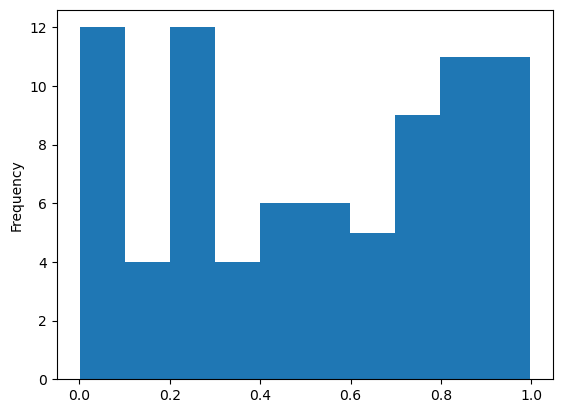

In [8]:
results_iid_df.PIT.plot(kind = "hist",bins=10)

### AR(1) model. Tasks A, B, C, D

In [9]:
results_ar1_df.head()

,product,mu,phi,sigma,expected_2019,MSE,PIT
0,0,107.12,0.41,15.26,179.80,1780.95,0.99
1,1,185.84,0.09,13.82,203.95,3.81,0.46
2,2,108.54,0.43,9.46,193.55,927.03,0.94
3,3,141.08,0.34,22.78,219.78,104.54,0.70
4,4,174.79,0.09,8.97,191.15,970.47,0.05


<Axes: ylabel='Frequency'>

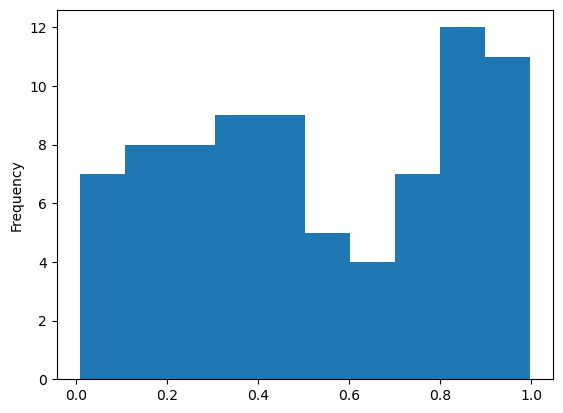

In [10]:
results_ar1_df.PIT.plot(kind = "hist",bins=10)

In [11]:
print(f'Среднее значение MSE для модели IID составляет: {round(results_iid_df["MSE"].mean(), 2)}')
print(f'Среднее значение MSE для модели AR(1) составляет: {round(results_ar1_df["MSE"].mean(), 2)}')

Среднее значение MSE для модели IID составляет: 491.41
Среднее значение MSE для модели AR(1) составляет: 420.94


Таким образом, вторая модель - AR (1) - делает более точные прогнозы, если судить по MSE. Принимая во вниманиегистограммы PIT, первая модель далека от равномерного распределения. Присутствуют признаки overconfidence (разброс оказался сильнее, чем мы ожидали, много выбросов. Мы недооценили стандартное отклонение). У второй же модели дела обстоят снова лучше: она ближе к равномерному распределению. Однако можно предположить, что присутствует pessimism (гистограмма идет правее и выше, то есть мы недооценили ожидаемый спрос), а также снова overconfidence.

## Problem 2

In [95]:
experts = pd.read_excel('Home Assignment 3 Data.xlsx', sheet_name=1) # читаем второй лист экселя
experts.rename(columns = {'Unnamed: 0': 'index'}, inplace = True)
experts.head()

,index,Sales,Stockout date,Keith,Brianna,Blair,Kelsey,Matthew,Dylan,Lavada
0,Product 1,105,2019-12-01,134,165,124,136,164,140,129
1,Product 2,105,2019-12-21,128,108,105,107,97,106,116
2,Product 3,39,NaT,39,47,43,45,43,66,22
3,Product 4,105,2019-12-20,105,112,114,119,115,119,108
4,Product 5,105,2019-12-17,118,129,140,117,103,127,114


In [123]:
expert_columns = experts.iloc[:, 3:10] # выбираем столбцы с экспертами, считаем для них среднее (prediction) и дисперсию
expert_columns['prediction'] = expert_columns.mean(axis=1) 
expert_columns['var'] = np.var(expert_columns, axis = 1, ddof = 2) # дисперсия посчитана выборочная (совпадает со значением функции ДИСП.В в эксель)
expert_columns.head()

,Keith,Brianna,Blair,Kelsey,Matthew,Dylan,Lavada,prediction,var
0,134,165,124,136,164,140,129,141.71,268.24
1,128,108,105,107,97,106,116,109.57,96.95
2,39,47,43,45,43,66,22,43.57,167.29
3,105,112,114,119,115,119,108,113.14,27.81
4,118,129,140,117,103,127,114,121.14,143.14


In [98]:
season_start = pd.to_datetime('2019-09-01')  # задаем начало и конец сезона продаж из условия
season_end = pd.to_datetime('2019-12-31')   
season_days = (season_end - season_start).days + 1  # считаем количество дней в сезоне

def uncensor_demand(stockout_date, order_quantity): # demand uncensoring на основе данных о продажах и assumption об их равномерном распределении
    if pd.isna(stockout_date): # если товар не закончился, значит, его продали меньше заказанного объема в 150 штук
        return order_quantity
    stockout_date = pd.to_datetime(stockout_date)
    days_sold = (stockout_date - season_start).days + 1 # считаем продажи
    return (order_quantity / days_sold) * season_days

experts['demand'] = experts.apply(lambda row: uncensor_demand(row['Stockout date'], row['Sales']), axis=1) # применяем написанную функцию
experts['prediction'] = expert_columns['prediction']  # средний прогноз, рассчитанный выше
experts['MSE'] = (experts['prediction'] - experts['demand'])**2  # квадратичная ошибка
experts['var'] = expert_columns['var']

expert = experts[['index', 'demand', 'prediction', 'MSE', 'var']].copy()

X = sm.add_constant(expert['var']) # строим регрессию на MSE с регрессором-дисперсией
y = expert['MSE']
model = sm.OLS(y, X).fit()
expert.loc[:, 'adj_var'] = model.predict(X) # находим adjusted variances
expert['adj_var'] = expert['adj_var'].apply(lambda x: max(x, 0.01)) # заменяем отрицательные значения (было одно) на 0.01

eval_mu = expert['prediction']
eval_sigma = model.predict(X)
expert['int1_50_l_1'] = ss.norm.ppf(0.25, loc = eval_mu, scale = eval_sigma) # строим 50%-ый доверительный интервал
expert['int1_50_u_1'] = ss.norm.ppf(0.75, loc = eval_mu, scale = eval_sigma)
expert['int1_50_coverage_1'] = (expert['demand'] >= expert['int1_50_l_1']) & (expert['demand'] <= expert['int1_50_u_1']) # подсчитываем покрытие реального 
                                                                                                                        #спроса нашим доверительным интервалом

try:
    wb = load_workbook(file_path) # сохраняем в ту же книгу эксель, что и первую проблему (лист experts)
    if 'experts' in wb.sheetnames:
        del wb['experts']
        wb.save(file_path)
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:  
        expert.to_excel(writer, sheet_name='experts', index=False)  
    print("Модели оценены и сохранены в файл 'model_parameters.xlsx'.")
except Exception as e:
    print(f"Ошибка при сохранении файла: {e}")

Модели оценены и сохранены в файл 'model_parameters.xlsx'.


### Tasks A (demand), B (prediction, MSE), C (var), D (adj_var), E (intervals)

In [87]:
expert.head()

,index,demand,prediction,MSE,var,adj_var,int1_50_l_1,int1_50_u_1,int1_50_coverage_1
0,Product 1,139.24,141.71,6.13,268.24,50.77,107.47,175.96,True
1,Product 2,114.38,109.57,23.07,96.95,17.46,97.79,121.35,True
2,Product 3,39.00,43.57,20.90,167.29,31.14,22.57,64.57,True
3,Product 4,115.41,113.14,5.12,27.81,4.02,110.43,115.85,True
4,Product 5,118.61,121.14,6.41,143.14,26.44,103.31,138.98,True


### Task C (plot)

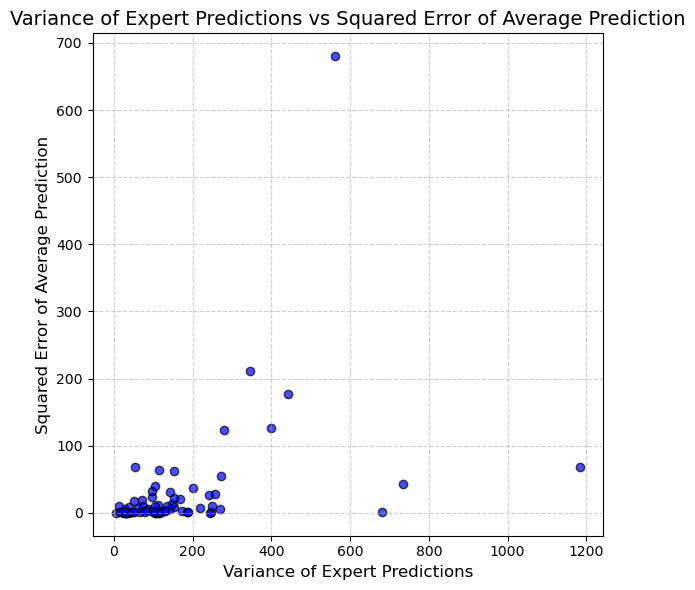

In [99]:
pt.figure(figsize=(6, 6))
pt.scatter(expert['var'], expert['MSE'], alpha=0.7, edgecolors='k', color='blue') # строим график по дисперсии и MSE
pt.title('Variance of Expert Predictions vs Squared Error of Average Prediction', fontsize=14)
pt.xlabel('Variance of Expert Predictions', fontsize=12)
pt.ylabel('Squared Error of Average Prediction', fontsize=12)
pt.grid(True, linestyle='--', alpha=0.6)
pt.tight_layout()

За исключением редких выбросов, можно наблюдать достаточно высокую концентрацию наблюдений ближе к 0. Зависимость на первый взгляд выявить сложно

### Task D: Регрессия squared errors на expert's variance (была задана выше, здесь просто саммери)

In [70]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MSE   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     14.18
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           0.000349
Time:                        17:39:53   Log-Likelihood:                -405.72
No. Observations:                  70   AIC:                             815.4
Df Residuals:                      68   BIC:                             819.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3882     12.892     -0.108      0.915     -27.113      24.337
var            0.2268      0.060      3.765      0.000       0.107       0.347
==============================================================================
Omnibus:                      115.655   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4059.435
Skew:                           5.228   Prob(JB):                         0.00
Kurtosis:                      38.812   Cond. No.                         286.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Task E: interval estimation

In [89]:
print('50% interval coverage model: ', round(expert['int1_50_coverage_1'].mean(),4))

50% interval coverage model:  0.9429


Покрытие высокое, однако это скорее связано с низким уровнем доверия (всего 50%)

## Problem 3

In [107]:
# 1. Expert predictions (Sheet 3, строки 2+, колонки A-E)
expert_predictions = pd.read_excel('Home Assignment 3 Data.xlsx', sheet_name='Sheet3', usecols='A:E', skiprows=1)

# 2. Event descriptions (Sheet 3, строки 2+, колонки G-K)
event_descriptions = pd.read_excel('Home Assignment 3 Data.xlsx', sheet_name='Sheet3', usecols='G:K', skiprows=1)
event_descriptions.rename(columns={'ifp_id.1': 'ifp_id_event'}, inplace=True)
event_descriptions.rename(columns={'outcome.1': 'outcome_event'}, inplace=True)

# 3. Prediction markets (Sheet 4, строки 2+, колонки A-C)
prediction_markets = pd.read_excel('Home Assignment 3 Data.xlsx', sheet_name='Sheet4', usecols='A:C', skiprows=1)
prediction_markets.rename(columns={'ifp_id': 'ifp_id_markets'}, inplace=True)
prediction_markets.rename(columns={'outcome': 'outcome_markets'}, inplace=True)

In [108]:
print("Expert Predictions:")
expert_predictions.head()

Expert Predictions:


,ifp_id,prob_yes,outcome,is_superforecaster,user_id
0,1040-0,0.80,1,0,1120
1,1040-0,0.99,1,1,1321
2,1040-0,0.01,1,1,140
3,1040-0,0.01,1,1,1405
4,1040-0,0.99,1,0,1441


In [109]:
print("\nEvent Descriptions:")
event_descriptions.head()


Event Descriptions:


,ifp_id_event,q_text,outcome_event,date_start,date_closed
0,1040-0,Will Aleksandr Lukashenko remain president of Belarus through 30 June 2012?,1.00,2011-11-08,2012-06-30T00:00:00Z
1,1047-0,"Will a foreign or multinational military force fire on, invade, or enter Iran before 1 September 2012?",0.00,2011-12-14,2012-08-31T00:00:00Z
2,1056-0,Will 1 Euro buy less than $1.20 US dollars at any point before 1 January 2013?,0.00,2012-01-09,2012-12-31T00:00:00Z
3,1061-0,Will Syria's Arab League membership be reinstated* by 31 December 2012?,0.00,2012-01-09,2012-12-31T00:00:00Z
4,1065-0,Will there be a significant* lethal confrontation involving government forces in the South China Sea or East China Sea between 23 January 2012 and 31 December 2012?,0.00,2012-01-23,2012-12-31T00:00:00Z


In [110]:
print("\nPrediction Markets:")
prediction_markets.head()


Prediction Markets:


,ifp_id_markets,prob_yes,outcome_markets
0,1047-0,0.10,0.00
1,1056-0,0.10,0.00
2,1061-0,0.01,0.00
3,1065-0,0.05,0.00
4,1081-0,0.04,0.00


### Question A. IFP ID 1184-0

In [111]:
event_1184 = event_descriptions[event_descriptions['ifp_id_event'] == '1184-0']
print("Описание события для IFP ID 1184-0:")
event_1184

Описание события для IFP ID 1184-0:


,ifp_id_event,q_text,outcome_event,date_start,date_closed
62,1184-0,"Before 1 April 2013, will substantial* evidence emerge that Iran has enriched any uranium above 27% purity?",0.00,2012-12-17,2013-03-31T00:00:00Z


### Question B. Average prediction and Brier Score

In [124]:
# Группировка и расчет средней вероятности для каждой группы (superforecaster / нет) по каждому событию
avg_probs = expert_predictions.groupby(['ifp_id', 'is_superforecaster'])['prob_yes'].mean().reset_index()

# Присоединяем исходы событий из event_descriptions
avg_probs = avg_probs.merge(event_descriptions[['ifp_id_event', 'outcome_event']], 
                            left_on='ifp_id', 
                            right_on='ifp_id_event')

# Рассчет Brier Score для каждой строки
avg_probs['brier_score'] = (avg_probs['prob_yes'] - avg_probs['outcome_event']) ** 2

# Группировка по событиям и разделение по is_superforecaster
mean_brier_scores = avg_probs.pivot_table(
    index='ifp_id_event',
    columns='is_superforecaster',
    values='brier_score',
    aggfunc='mean').reset_index()

# Переименование колонок для удобства
mean_brier_scores.rename(columns={0: 'brier_score_non_super', 1: 'brier_score_super'}, inplace=True)

# Вывод таблицы
print("Таблица средних Brier Score по каждому событию:")
print(mean_brier_scores)

# Итоговые средние для двух групп
mean_super = mean_brier_scores['brier_score_super'].mean().round(3)
mean_non_super = mean_brier_scores['brier_score_non_super'].mean().round (3)

print("\nСредний Brier Score для superforecasters по всем событиям:", mean_super)
print("Средний Brier Score для обычных прогнозистов по всем событиям:", mean_non_super)
print ()

# Проверка событий, где обычные прогнозисты лучше
better_non_super = mean_brier_scores[
    mean_brier_scores['brier_score_non_super'] < mean_brier_scores['brier_score_super']
]
print("События, где обычные прогнозисты показали себя лучше суперпрогнозистов:")
print(better_non_super)

Таблица средних Brier Score по каждому событию:
is_superforecaster ifp_id_event  brier_score_non_super  brier_score_super
0                        1040-0                   0.03               0.01
1                        1047-0                   0.04               0.01
2                        1056-0                   0.30               0.00
3                        1061-0                   0.04               0.00
4                        1065-0                   0.07               0.00
..                          ...                    ...                ...
75                       1204-0                   0.20               0.01
76                       1208-4                   0.11               0.02
77                       1210-2                   0.11               0.04
78                       1211-1                   0.15               0.02
79                       1212-0                   0.08               0.01

[80 rows x 3 columns]

Средний Brier Score для superforecasters

По некоторым событиям superforecasters показывают удивительные результаты, близкие к 0.
В среднем superforcasters показывали лучшие результаты с довольно большим отрывом.
Только в 6 событиях из 80 обычные прогнозисты показали лучшие результаты.

### Question С. Extremizing predictions

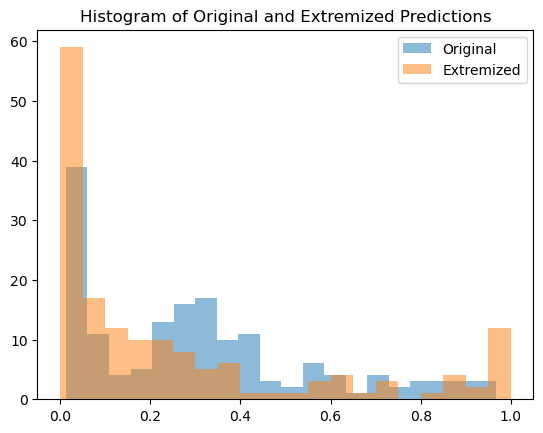

In [113]:
avg_probs['ext_prob'] = ss.norm.cdf(2 * ss.norm.ppf(avg_probs['prob_yes']))

# Построение гистограмм
pt.hist(avg_probs['prob_yes'], bins=20, alpha=0.5, label='Original')
pt.hist(avg_probs['ext_prob'], bins=20, alpha=0.5, label='Extremized')
pt.legend()
pt.title("Histogram of Original and Extremized Predictions")
pt.show()

Суть extremization: прогнозы около 0,5 довольно нейтральные и не дают в полной мере сигнала о вероятности исхода. Extremization делает прогнозы более конкретными - либо ближе к 0, либо ближе к 1. Как можно заметить, меньше значений стало в середине и больше по краям. 

### Question D. Brier Score after extremization

In [116]:
# Рассчитываем Brier Score after extremization
avg_probs['ext_brier_score'] = (avg_probs['ext_prob'] - avg_probs['outcome_event']) ** 2

# Группировка и вычисление среднего Brier Score after extremization
ext_brier_scores = avg_probs.groupby('is_superforecaster').agg(
    mean_ext_brier_score=('ext_brier_score', 'mean')
).reset_index()

# Выводим результаты
print("Средний Brier Score after extremization:")
print(ext_brier_scores.to_string(formatters={'mean_ext_brier_score': '{:.3f}'.format}))

Средний Brier Score after extremization:
   is_superforecaster mean_ext_brier_score
0                   0                0.127
1                   1                0.074


Интересно получилось, что для обычных прогнозистов качество прогнозов улучшилось (0.127 против 0.154), 
а для superforecasters ухудшилось (0.074 против 0.065)

### Question E. Сравнение с Prediction Markets

In [120]:
# Сначала рассчитываем Brier Score для прогнозов рынков
market_data = prediction_markets.merge(event_descriptions[['ifp_id_event', 'outcome_event']],
                                       left_on='ifp_id_markets', right_on='ifp_id_event')

market_data['market_brier_score'] = (market_data['prob_yes'] - market_data['outcome_event']) ** 2

# Средний Brier Score для каждого события и для каждой группы (не superforecasters, superforecasters, markets)
avg_super = avg_probs[avg_probs['is_superforecaster'] == 1].groupby('ifp_id_event')['brier_score'].mean().reset_index()
avg_non_super = avg_probs[avg_probs['is_superforecaster'] == 0].groupby('ifp_id_event')['brier_score'].mean().reset_index()
avg_markets = market_data.groupby('ifp_id_event')['market_brier_score'].mean().reset_index()

# Соединяем все данные по событиям
combined_scores = avg_super.merge(avg_non_super, on='ifp_id_event', suffixes=('_super', '_non_super'))
combined_scores = combined_scores.merge(avg_markets, on='ifp_id_event')

# Оставляем только те события, которые есть в трех группах
combined_scores = combined_scores.dropna()

# Создаем таблицу с четырьмя колонками
combined_scores = combined_scores[['ifp_id_event', 'brier_score_non_super', 'brier_score_super', 'market_brier_score']]

# Проверка, у кого наименьшее значение Brier Score для каждого события
min_brier_super = (combined_scores['brier_score_super'] < combined_scores[['brier_score_non_super', 'market_brier_score']].min(axis=1)).sum()
min_brier_non_super = (combined_scores['brier_score_non_super'] < combined_scores[['brier_score_super', 'market_brier_score']].min(axis=1)).sum()
min_brier_markets = (combined_scores['market_brier_score'] < combined_scores[['brier_score_non_super', 'brier_score_super']].min(axis=1)).sum()

# Средние значения Brier Score по каждой группе
mean_super = combined_scores['brier_score_super'].mean()
mean_non_super = combined_scores['brier_score_non_super'].mean()
mean_markets = combined_scores['market_brier_score'].mean()

# Выводим таблицу и результаты
print("Таблица Brier Score для событий:")
print(combined_scores)

print("\nВ скольких событиях наименьшее значение Brier Score:")
print(f"Markets: {min_brier_markets}")
print(f"Superforecasters: {min_brier_super}")
print(f"Non-superforecasters: {min_brier_non_super}")

print("\nСреднее Brier Score по всем группам:")
print(f"Markets: {mean_markets:.3f}")
print(f"Superforecasters: {mean_super:.3f}")
print(f"Non-superforecasters: {mean_non_super:.3f}")

Таблица Brier Score для событий:
   ifp_id_event  brier_score_non_super  brier_score_super  market_brier_score
0        1047-0                   0.04               0.01                0.01
1        1056-0                   0.30               0.00                0.01
2        1061-0                   0.04               0.00                0.00
3        1065-0                   0.07               0.00                0.00
4        1081-0                   0.14               0.01                0.00
..          ...                    ...                ...                 ...
74       1204-0                   0.20               0.01                0.00
75       1208-4                   0.11               0.02                0.21
76       1210-2                   0.11               0.04                0.08
77       1211-1                   0.15               0.02                0.04
78       1212-0                   0.08               0.01                0.00

[79 rows x 4 columns]

В сколь

В среднем superforecasters показывали лучшие результаты по сравнению с regulars и markets.
В то же время superforecasters показали наилучший результат среди трех групп в 38 событиях, а markets - в 35,
то есть отрыв не такой большой